# Projektaufgabe - Roundtrip-Path

Implementieren Sie einen Roundtrip-Path Planer

1. Gegeben sind  
    1. Startposition  
    2. Mehrere Endpositionen
    3. Das Interface des Roundtrip-Path-Planners soll sich *nicht* von den anderen Bahnplanern unterscheiden.
    4. Der zu verwendete Bahnplanungsalgorithmus soll wählbar sein und geeignet übertragen werden können.
    5. Ausgabe: Ein kollisionsfreier Pfad, der von der gegebenen Startposition alle Endpositionen genau einmal erreicht und wieder zur Startposition zurückführt. Dabei soll der Gesamtpfad möglichst kurz sein. Koordinieren Sie den Pfad geeignet (z.B. farblich), so dass sich erkennen lässt, was Start-Punkt, kollisionsfreier Zwischenpfad und Zielpunkte sind. \
    *Anmerkung: NetworkX hat prinzipiell die Möglichkeit auf einem gegebenen Graph dieses Problem zu lösen, sogar auf verschiedene Arten und Weisen. Sie können dies nutzen*

In [14]:
import networkx as nx
from IPPerfMonitor import IPPerfMonitor

In [ ]:
class Roundtrip_path_planner:

    def __init__(self, path_planner):
        assert hasattr(path_planner, "planPath"), "path_planner must have a method called 'planPath'"
        self.path_planner = path_planner

    
    @IPPerfMonitor
    def planPath(self, startList, goalList, config):
        path = self.path_planner.planPath(startList, goalList, config)
        #nx.traveling_salesman_problem()
        return path


2. Evaluieren Sie ihr Konzept mit BasicPRM, LazyPRM, VisibilityPRM anhand von mindestens 6 Benchmarkumgebungen (3 * 2-DoF Punktroboter, 3 * Planarroboter). Die Szenen der Benchmarkaufgaben für die 2-DoF Punktroboter sollen unterschiedlich aussehen und unterschiedlich schwer sein. Die Szene der Benchmarkaufgaben für die Planarroboter können gleich sein und lediglich die Anzahl der Freiheitsgrade und Start, Ziel und Zwischenpunkte verändert werden.
    1. Betrachten Sie z.B. Anzahl der Kollisionsberechnungen, Planungszeit, Roadmapgröße, Länge Lösungspfad und Stellen Sie die Ergebnisse graphisch dar und diskutieren Sie diese.
    2. Für die 2-DoF Punkt- und Planarroboter stellen Sie sowohl die Vorgehensweise des Roundtrip-Planers (welche Bahnen werden wann geplant, was ist das finale Ergebnis) als auch das Endergebnis als Animation (s. IP-10-0-PlanarManipulator.ipnyb) dar.

In [30]:
import matplotlib.pyplot as plt
from IPBenchmark import Benchmark
from shapely.geometry import Point, Polygon, LineString

from IPEnvironment import CollisionChecker
from IPVISBasicPRM import basicPRMVisualize
import IPTestSuite as ts

from IPVisibilityPRM import VisPRM

/home/johannes/miniconda3/envs/intro-path-planning/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


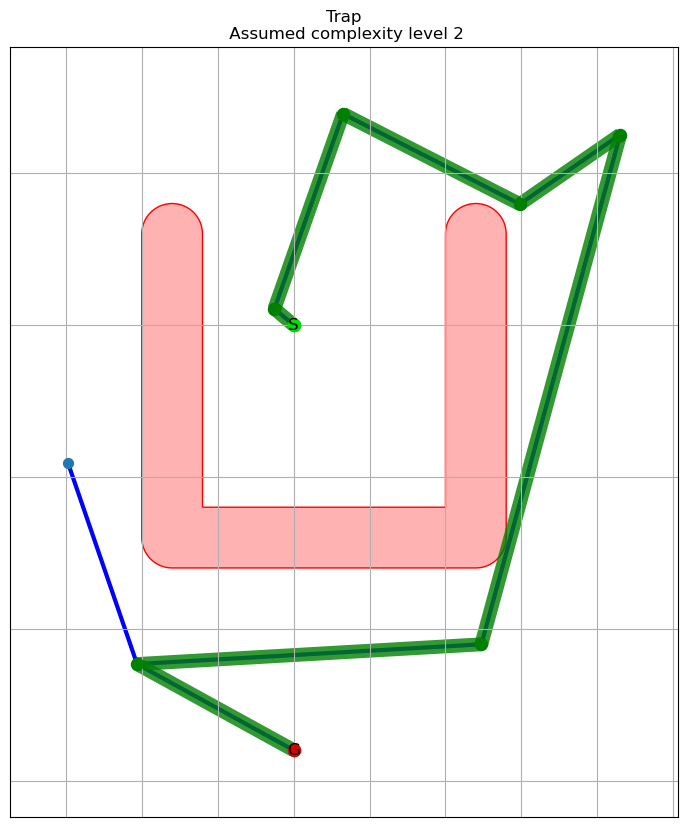

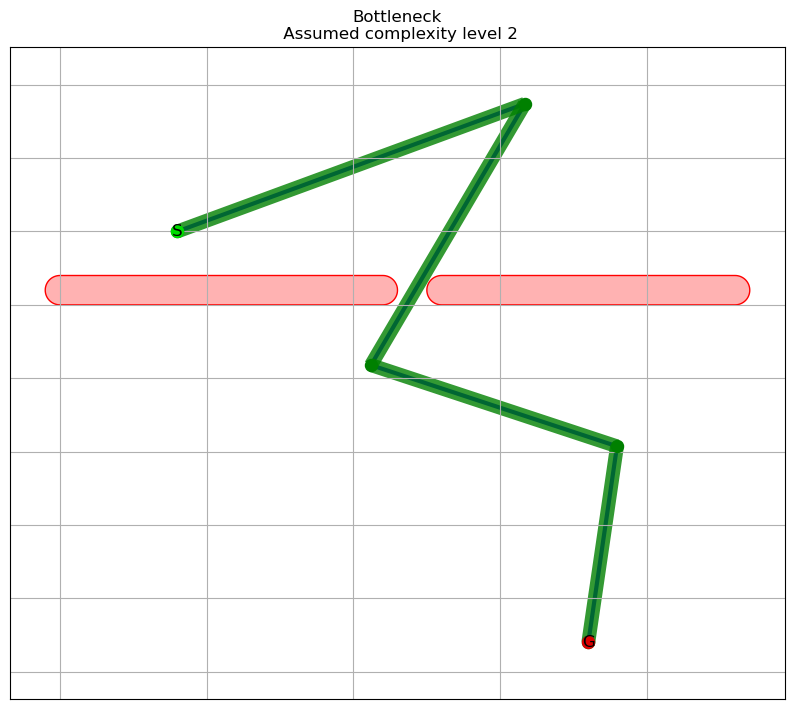

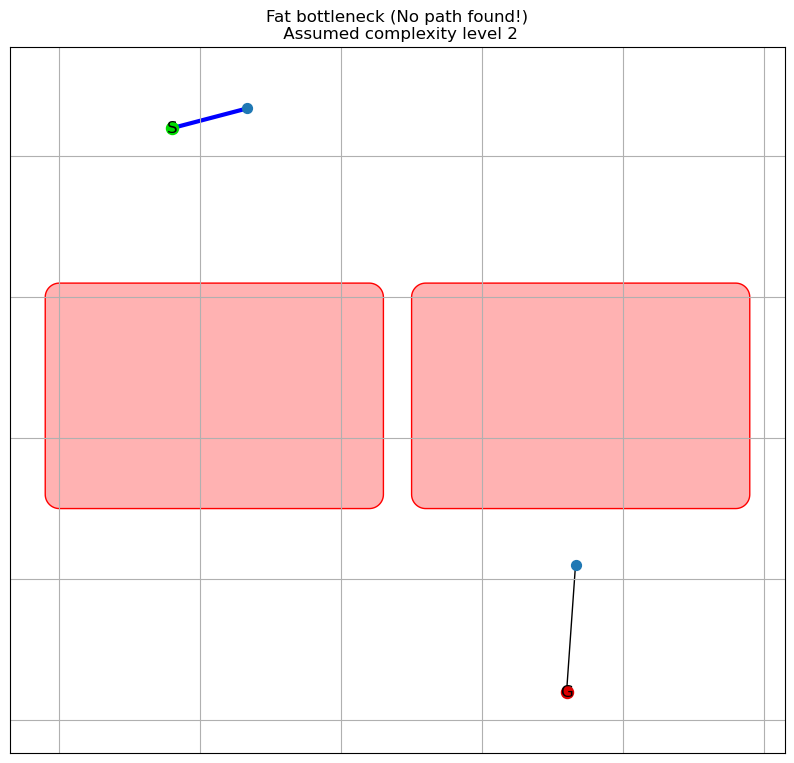

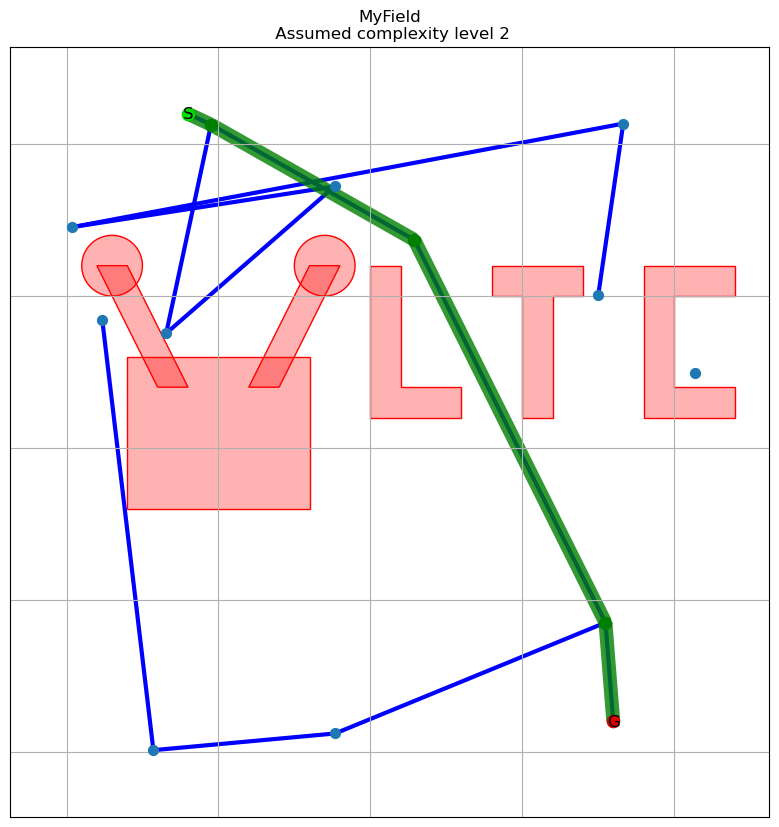

In [34]:
visConfig = dict()
visConfig["ntry"] = 40

for benchmark in ts.benchList:
    try:
        fig_local = plt.figure(figsize=(10,10))
        ax = fig_local.add_subplot(1,1,1)
        planner = VisPRM(benchmark.collisionChecker)
        roadmap_planner = Roundtrip_path_planner(planner)
        solution = roadmap_planner.planPath(benchmark.startList, benchmark.goalList, visConfig)
        title = benchmark.name
        if solution == []:
            title += " (No path found!)"
        title += "\n Assumed complexity level " + str(benchmark.level)
        ax.set_title(title)
        basicPRMVisualize(roadmap_planner.path_planner, solution, ax=ax, nodeSize=50)
    except Exception as e:
        print("ERROR: ",benchmark.name, e)

3. In einem weiteren Schritt entwickeln Sie eine spezielle Variante auf Basis des VisibilityPRM. Wie Sie wissen, ist dieser für Multi-Query Anfragen vorteilhaft nutzbar. Nutzen Sie dies für das Roundtrip-Konzept. Hier müssen Sie eventuell die Art wie Sie den Visibility-PRM aufrufen geschickt verändern. Führen Sie ebenfalls die Evaluation an den Benchmarkumgebungen durch und vergleichen Sie die Ergebnisse mit den Versionen aus 2.) 

Erkläutern Sie bitte zudem im Endbericht (mind. 1 Seite):
1. Wie funktioniert der Roundtrip-Planer, den Sie verwenden im Detail und warum haben Sie diesen gewählt.
2. Wie können Sie die Bewegungsbahnen optimieren/Glätten? Erläutern SIe kurz eine mögliche Vorgehensweise.

Anmerkung: Bitte checken Sie das Notebook "IP-X-0-Benchmarking-concept.ipnyb" und "IP-X-1-Automated_PlanerTest.ipnyb" für Profiling und Statistiken.